# Robust Logistic Regression

Author: https://github.com/deburky

In this notebook, we will implement robust logistic regression using the Fisher scoring algorithm.

$$
\begin{align*}
&\tilde{p}(y_i \mid \mathbf{x}_i, \beta) = (1-\epsilon)\, p(y_i \mid \mathbf{x}_i, \beta) + \epsilon\, q(y_i) \\
&\quad\text{where } q(y_i)\text{ is } 0.5,\ \epsilon\text{ is } 0.05 \\[1.5em]
&w_i = \frac{(1-\epsilon)\, p(y_i \mid \mathbf{x}_i, \beta)}
           {(1-\epsilon)\, p(y_i \mid \mathbf{x}_i, \beta) + \epsilon\, q(y_i)} \\[1.5em]

&\qquad\text{If } q(y_i) = 0.5,\ \epsilon = 0.05: \\[0.7em]
&w_i = \frac{0.95\, p(y_i \mid \mathbf{x}_i, \beta)}
           {0.95\, p(y_i \mid \mathbf{x}_i, \beta) + 0.025} \\[1.5em]
&p_i = \sigma(\mathbf{x}_i^\top \beta),\qquad \sigma(z) = \frac{1}{1 + e^{-z}} \\[1.5em]
&\mathbf{S} = \sum_{i=1}^n w_i (y_i - p_i) \mathbf{x}_i \\[1.5em]
&\mathcal{I} = \sum_{i=1}^n w_i\, p_i (1-p_i)\, \mathbf{x}_i \mathbf{x}_i^\top \\[1.5em]
&\beta_{\text{new}} = \beta_{\text{old}} + \mathcal{I}^{-1} \mathbf{S}
\end{align*}
$$

The adaptation is from a book example in *Probabilistic Machine Learning: An Introduction*.

The book illustrates robust logistic regression with a Bayesian approach and discusses SGD as an alternative. Here, we show how this can be implemented using the Fisher Scoring algorithm.

<div align="center"> <img src="https://dhjhkxawhe8q4.cloudfront.net/mit-press/wp-content/uploads/2023/05/25155058/9780262046824.jpg" width="120" style="margin-bottom:12px;"> <br> <sup>Kevin P. Murphy, <i>Probabilistic Machine Learning: An Introduction</i>, MIT, 2022.</sup> </div>

In [1]:
import numpy as np
from fisher_scoring import LogisticRegression
from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid
from scipy.stats import norm
import numpy as np

In [2]:
def robust_logistic_regression(X, y, epsilon=0.05, max_iter=30, tol=1e-6):
    """Robust Logistic Regression."""
    _, n_features = X.shape
    beta = np.zeros(n_features)
    q = 0.5 * np.ones_like(y, dtype=float)
    for _ in range(max_iter):
        z = X @ beta
        p = sigmoid(z)

        # Assign class probabilities
        p_model = np.where(y == 1, p, 1 - p)

        # Calculate weights
        numerator = (1 - epsilon) * p_model
        denominator = numerator + epsilon * q
        w = numerator / denominator

        # Calculate weights and score
        W_diag = w * p * (1 - p)
        score = X.T @ (w * (y - p))

        # Calculate weighted Fisher information
        fisher_info = X.T @ (W_diag[:, np.newaxis] * X)

        try:
            beta_new = np.linalg.inv(fisher_info) @ score
        except np.linalg.LinAlgError:
            beta_new = np.linalg.pinv(fisher_info) @ score
        beta += beta_new
        if np.linalg.norm(beta_new) < tol:
            break
    return beta


# Generate data
np.random.seed(0)
X = np.linspace(-4, 4, 100).reshape(-1, 1)
y = (np.random.rand(100) < sigmoid(1.2 * X[:, 0])).astype(int)
y[5] = 1  # Outlier
y[95] = 0  # Outlier

# Add bias column
X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

# Fit robust model
beta_robust = robust_logistic_regression(X_with_bias, y, epsilon=0.05)

# For plotting robust
X_grid = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
X_grid_with_bias = np.hstack([np.ones((X_grid.shape[0], 1)), X_grid])
probs_robust = sigmoid(X_grid_with_bias @ beta_robust)

# Robust CIs
z_final = X_with_bias @ beta_robust
p_final = sigmoid(z_final)
p_model_final = np.where(y == 1, p_final, 1 - p_final)
numer = (1 - 0.05) * p_model_final
denom = numer + 0.05 * 0.5
w_final = numer / denom
W_diag_final = w_final * p_final * (1 - p_final)
fisher_info_final = X_with_bias.T @ (W_diag_final[:, np.newaxis] * X_with_bias)
cov_beta = np.linalg.inv(fisher_info_final)
linear_preds = X_grid_with_bias @ beta_robust
std_errs = np.sqrt(np.sum(X_grid_with_bias @ cov_beta * X_grid_with_bias, axis=1))
z_crit = norm.ppf(1 - 0.05 / 2)
lower_logit = linear_preds - z_crit * std_errs
upper_logit = linear_preds + z_crit * std_errs
lower_prob = sigmoid(lower_logit)
upper_prob = sigmoid(upper_logit)

lr = LogisticRegression()
lr.fit(X, y)  # X is shape (n,1), class handles bias internally

predicted_probs = lr.predict_proba(X_grid)[:, 1]
predicted_cis = lr.predict_ci(X_grid)

print(f"Robust beta: {beta_robust}")
print(f"Standard beta: {lr.beta.flatten()}")

Robust beta: [0.34060812 1.94833422]
Standard beta: [0.17626843 1.06093251]


The robust weight for each observation is:
$$
w_i = \frac{0.95\, p(y_i \mid \mathbf{x}_i, \beta)}{0.95\, p(y_i \mid \mathbf{x}_i, \beta) + 0.025}
$$

**Examples:**

- **Inlier** (model predicts $y_i$ well, $p \approx 1$):

  $$
  w_i \approx \frac{0.95}{0.95 + 0.025} \approx 0.97 \quad \text{(large weight)}
  $$

- **Outlier** (model predicts $y_i$ poorly, $p \approx 0$):

 $$
  w_i \approx \frac{0}{0.025} = 0 \quad \text{(almost zero weight)}
 $$

Outliers get downweighted, so they have minimal effect on the robust logistic regression fit.

## Visualization

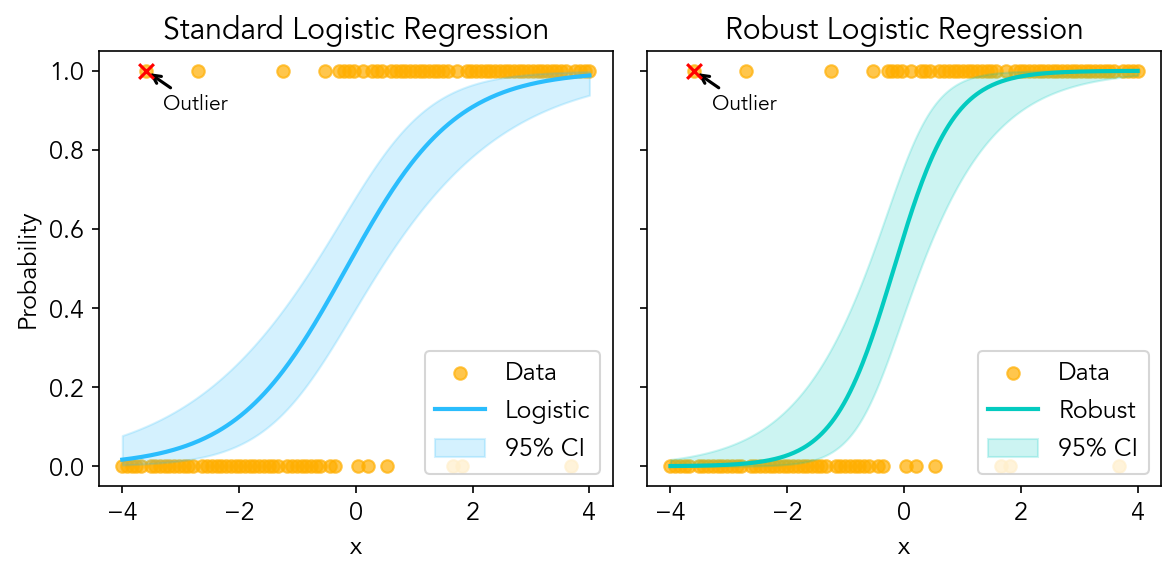

In [3]:
# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 12

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, dpi=150)

colors = [
    "#2ABDFD",
    "#03CBC0",
    "#FFAF01",
]

outlier_indices = [5, 95]

# Plot standard logistic regression
ax = axes[0]
ax.scatter(X[:, 0], y, color=colors[2], alpha=0.7, label="Data")
ax.plot(X_grid, predicted_probs, color=colors[0], lw=2, label="Logistic")
ax.fill_between(
    X_grid.flatten(),
    predicted_cis[:, 0],
    predicted_cis[:, 1],
    color=colors[0],
    alpha=0.2,
    label="95% CI",
)
ax.set_xlabel("x")
ax.set_ylabel("Probability")
ax.set_title("Standard Logistic Regression")
ax.legend(loc="lower right")
ax.scatter(X[5, 0], y[5], color="red", s=50, marker="x", zorder=5, label="Outlier")
ax.annotate(
    "Outlier",
    xy=(X[5, 0], y[5]),
    xytext=(X[5, 0] + 0.3, y[5] - 0.1),
    fontsize=10,
    color="black",
    weight="bold",
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
)

# Robust Logistic Regression
ax = axes[1]
ax.scatter(X[:, 0], y, color=colors[2], alpha=0.7, label="Data")
ax.plot(X_grid, probs_robust, color=colors[1], lw=2, label="Robust")
ax.fill_between(
    X_grid.flatten(), lower_prob, upper_prob, color=colors[1], alpha=0.2, label="95% CI"
)
ax.set_xlabel("x")
ax.set_title("Robust Logistic Regression")
ax.legend(loc="lower right")

ax.scatter(X[5, 0], y[5], color="red", s=50, marker="x", zorder=5, label="Outlier")
ax.annotate(
    "Outlier",
    xy=(X[5, 0], y[5]),
    xytext=(X[5, 0] + 0.3, y[5] - 0.1),
    fontsize=10,
    color="black",
    weight="bold",
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
)

plt.tight_layout()
plt.show()

## Density plot

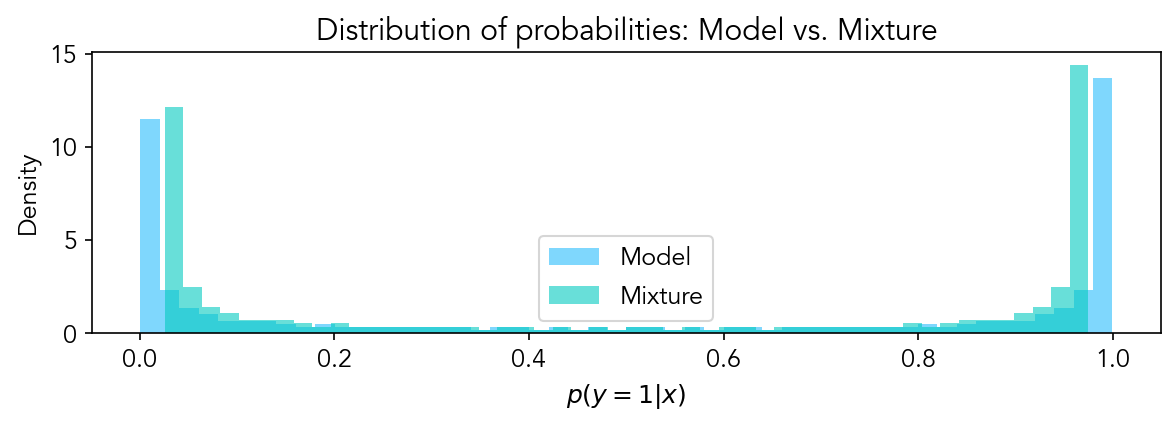

In [4]:
# Example beta, probabilities, as in your code above
beta = beta_robust
epsilon = 0.05

X_grid = np.linspace(-4, 4, 300)
X_grid_with_bias = np.column_stack([np.ones_like(X_grid), X_grid])

p_model = sigmoid(X_grid_with_bias @ beta)
p_contam = np.full_like(p_model, 0.5)
p_mixture = (1 - epsilon) * p_model + epsilon * p_contam

plt.figure(figsize=(8, 3), dpi=150)
plt.hist(p_model, bins=50, alpha=0.6, color="#2ABDFD", label="Model", density=True)
plt.hist(p_mixture, bins=50, alpha=0.6, color="#03CBC0", label="Mixture", density=True)
plt.xlabel("$p(y=1|x)$")
plt.ylabel("Density")
plt.title("Distribution of probabilities: Model vs. Mixture")
plt.legend()
plt.tight_layout()
plt.show()

## Gradient maps

In [5]:
# Robust Logistic Gradient
def robust_logistic_gradient(beta, X, y, epsilon=0.05):
    """Robust Logistic Gradient."""
    z = X @ beta
    p = sigmoid(z)
    p_model = np.where(y == 1, p, 1 - p)
    numer = (1 - epsilon) * p_model
    denom = numer + epsilon * 0.5
    w = numer / denom
    return X.T @ (w * (y - p))


# Standard Logistic Gradient
def standard_logistic_gradient(beta, X, y):
    """Standard Logistic Gradient."""
    z = X @ beta
    p = sigmoid(z)
    return X.T @ (y - p)


# Data (2 features + bias)
np.random.seed(0)
X = np.linspace(-4, 4, 100).reshape(-1, 1)
X2 = np.sin(X[:, 0]).reshape(-1, 1)
X_full = np.hstack([X, X2])
X_with_bias = np.hstack([np.ones((X_full.shape[0], 1)), X_full])
y = (np.random.rand(100) < sigmoid(1.2 * X[:, 0])).astype(int)
y[5] = 1
y[95] = 0

# Fit Robust Model (use X_with_bias)
beta_robust = np.zeros(X_with_bias.shape[1])
for _ in range(30):
    grad = robust_logistic_gradient(beta_robust, X_with_bias, y, epsilon=0.05)
    z = X_with_bias @ beta_robust
    p = sigmoid(z)
    p_model = np.where(y == 1, p, 1 - p)
    numer = (1 - 0.05) * p_model
    denom = numer + 0.05 * 0.5
    w_final = numer / denom
    W_diag = w_final * p * (1 - p)
    fisher_info = X_with_bias.T @ (W_diag[:, None] * X_with_bias)
    try:
        delta = np.linalg.solve(fisher_info, grad)
    except np.linalg.LinAlgError:
        delta = np.linalg.pinv(fisher_info) @ grad
    beta_robust += delta
    if np.linalg.norm(delta) < 1e-6:
        break

# Fit Standard Model
lr = LogisticRegression()
lr.fit(X_full, y)
beta_logistic = lr.beta.flatten()  # Already includes bias term

# Mesh grid for (w1, w2), fixing bias at MLE
w1_range = np.linspace(beta_logistic[1] - 1, beta_logistic[1] + 1, 100)
w2_range = np.linspace(beta_logistic[2] - 1, beta_logistic[2] + 1, 100)
B1, B2 = np.meshgrid(w1_range, w2_range)
grad_norms_logistic = np.zeros_like(B1)
grad_norms_robust = np.zeros_like(B1)
fixed_bias = beta_logistic[0]

for j in range(B1.shape[0]):
    for k in range(B1.shape[1]):
        weights = np.array([fixed_bias, B1[j, k], B2[j, k]])
        grad_logistic = standard_logistic_gradient(weights, X_with_bias, y)
        grad_robust = robust_logistic_gradient(weights, X_with_bias, y, epsilon=0.05)
        grad_norms_logistic[j, k] = np.linalg.norm(grad_logistic)
        grad_norms_robust[j, k] = np.linalg.norm(grad_robust)

# Normalize
grad_norms_logistic /= grad_norms_logistic.max()
grad_norms_robust /= grad_norms_robust.max()

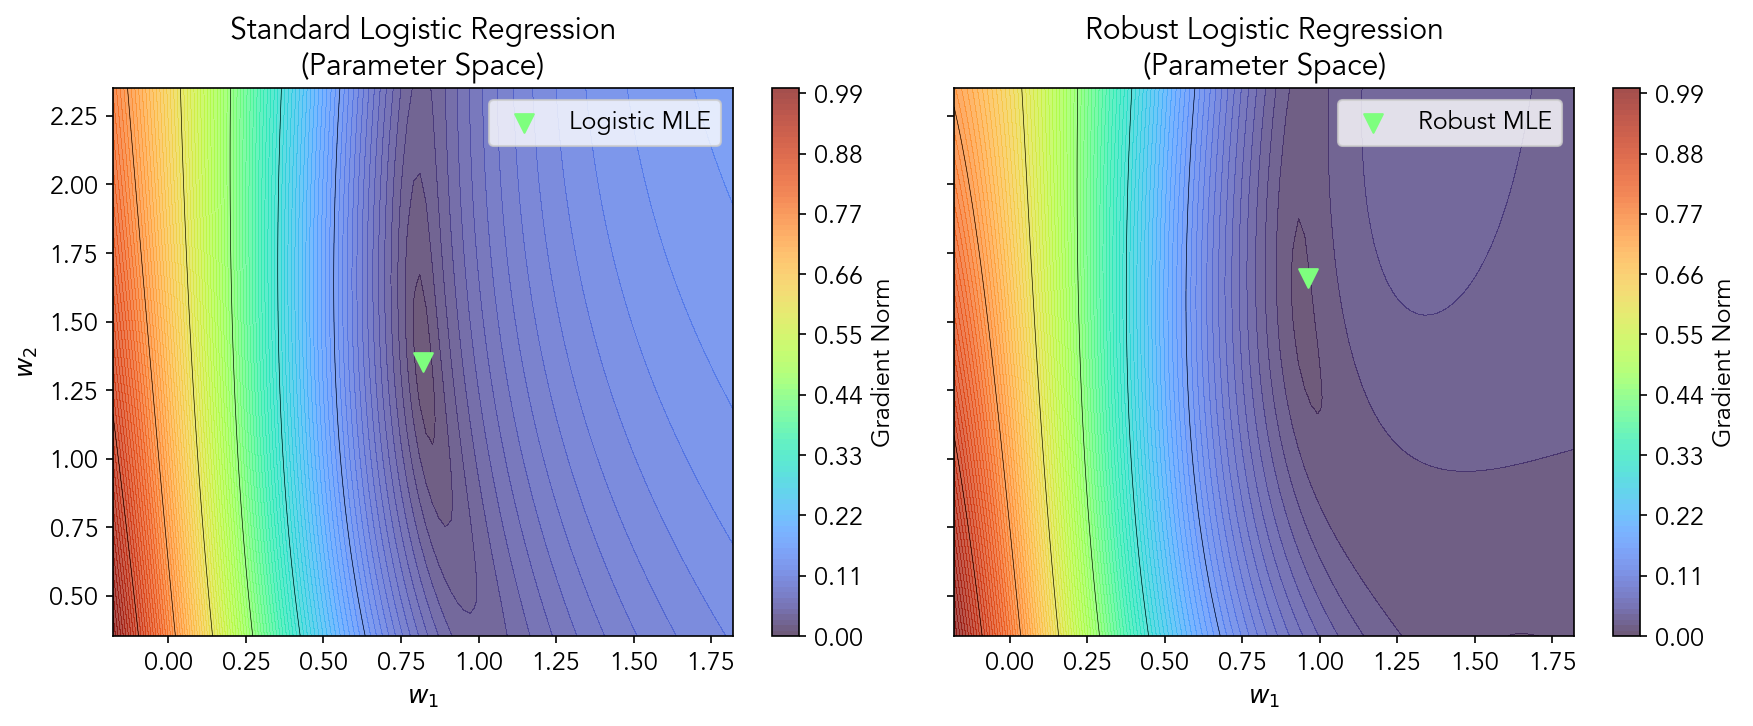

In [6]:
LEVELS = 100
CMAP = "turbo"
COLOR = "#7eff7e"

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150, sharey=True)

# Standard
c1 = axes[0].contourf(B1, B2, grad_norms_logistic, levels=LEVELS, cmap=CMAP, alpha=0.7)
axes[0].contour(B1, B2, grad_norms_logistic, colors="black", linewidths=0.3)
axes[0].scatter(
    beta_logistic[1],
    beta_logistic[2],
    color=COLOR,
    s=80,
    marker="v",
    label="Logistic MLE",
)
axes[0].set_title("Standard Logistic Regression\n(Parameter Space)")
axes[0].set_xlabel("$w_1$")
axes[0].set_ylabel("$w_2$")
cb1 = fig.colorbar(c1, ax=axes[0], shrink=1.0)
cb1.set_label("Gradient Norm")
axes[0].legend()

# Robust
c2 = axes[1].contourf(B1, B2, grad_norms_robust, levels=LEVELS, cmap=CMAP, alpha=0.7)
axes[1].contour(B1, B2, grad_norms_robust, colors="black", linewidths=0.3)
axes[1].scatter(
    beta_robust[1],
    beta_robust[2],
    color=COLOR,
    s=80,
    marker="v",
    label="Robust MLE",
)
axes[1].set_title("Robust Logistic Regression\n(Parameter Space)")
axes[1].set_xlabel("$w_1$")
cb2 = fig.colorbar(c2, ax=axes[1], shrink=1.0)
cb2.set_label("Gradient Norm")
axes[1].legend()

plt.tight_layout()
plt.show()

## fisher-scoring package

In [7]:
from fisher_scoring import RobustLogisticRegression

rlr = RobustLogisticRegression()
rlr.fit(X, y)

rlr.display_summary(style="dodger_blue1")

╭─ Robust Fisher Scoring Logistic Regression Fit ─╮
│                                                 │
│         Total Fisher Scoring Iterations: 48     │
│         Weighted Log Likelihood: -19.8068       │
│         Beta 0 = intercept (bias): True         │
│         Epsilon Contamination: 0.050            │
│         Average Robust Weight: 0.931            │
│         Minimum Robust Weight: 0.020            │
│                                                 │
╰─────────────────────────────────────────────────╯

                  Robust Fisher Scoring Logistic Regression Summary                   
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│    Beta 0 │ 0.3407   │ 0.4145     │ 0.8220         │ 0.4111  │ -0.4716  │ 1.1531   │
│    Beta 1 │ 1.9487   │ 0.4438     │ 4.3911         │ 0.0000  │ 1.0789   │ 2.8186   │
└───────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘